# 0.0 Imports

In [66]:
# data manipulation
import pandas as pd
import numpy  as np

# data visutalization
import matplotlib.pyplot as plt
import seaborn           as sns

# stats
import scipy as ss

#encoding
from imblearn.combine      import SMOTETomek
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# feature selection
from boruta                    import BorutaPy
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# modeling
from sklearn.ensemble    import RandomForestClassifier
from sklearn.ensemble    import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn             import base
from sklearn             import linear_model as lm
from sklearn             import neighbors    as nh
import                          xgboost      as xgb

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#metrics
import scikitplot as skplt
from   sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

# tuning
import optuna

#display
from IPython.display       import Image
from IPython.core.display  import HTML

## 0.1 Helper Functions

In [81]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'fivethirtyeight' )
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    #sns.set()
    sns.set_style('ticks')
    

def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m



class KFoldTargetEncoder(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        
        return self
    
    
    def transform(self,X):
    
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2021)
        print(kf)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            
            #train set and validation set
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            
            #test set you take the average of the target values of all samples that have a given category in the entire train set.
            X[col_mean_name].fillna(mean_of_target, inplace = True)
            
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            
        return X



def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']



def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


    

def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    precision_k_list = []
    recall_k_list = []
    balanced_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 4000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 4000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)

        balanced_accuracy = balanced_accuracy_score(y_val_fold, yhat_1)
        balanced_list.append(balanced_accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Balanced Accuracy Mean': np.mean(balanced_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [6]:
df = pd.read_csv('../data/raw/train.csv')

# 1.0 Data Description

In [7]:
df1 = df.copy()

In [8]:
df1.columns = map(str.lower, df1.columns)

In [9]:
df1.head(10)

id  gender  age  driving_license  region_code  previously_insured vehicle_age vehicle_damage  annual_premium  policy_sales_channel  vintage  response
0   1    Male   44                1         28.0                   0   > 2 Years            Yes         40454.0                  26.0      217         1
1   2    Male   76                1          3.0                   0    1-2 Year             No         33536.0                  26.0      183         0
2   3    Male   47                1         28.0                   0   > 2 Years            Yes         38294.0                  26.0       27         1
3   4    Male   21                1         11.0                   1    < 1 Year             No         28619.0                 152.0      203         0
4   5  Female   29                1         41.0                   1    < 1 Year             No         27496.0                 152.0       39         0
5   6  Female   24                1         33.0                   0    < 1 Year            Yes          2630.0                 160.0      176         0
6   7    Male   23                1         11.0                   0    < 1 Year            Yes         23367.0                 152.0      249         0
7   8  Female   56                1         28.0                   0    1-2 Year            Yes         32031.0                  26.0       72         1
8   9  Female   24                1          3.0                   1    < 1 Year             No         27619.0                 152.0       28         0
9  10  Female   32                1          6.0                   1    < 1 Year             No         28771.0                 152.0       80         0

In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [12]:
cons = pd.DataFrame({'colunas' : df.columns,
                    'tipo': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unicos': df.nunique()})

cons['percentual'] = round(cons['missing'] / cons['size'],2)

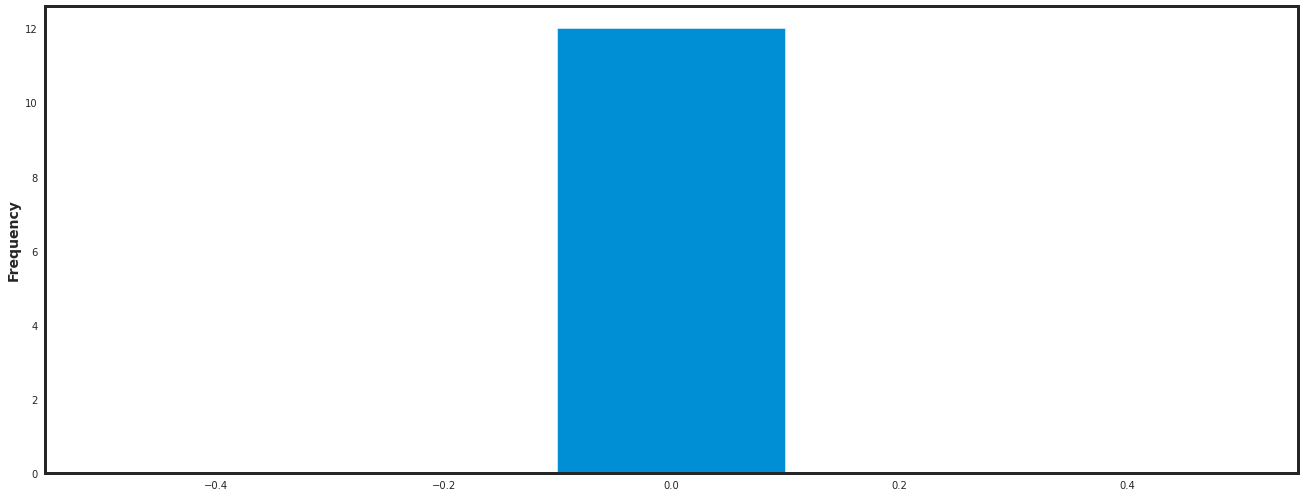

In [13]:
cons.percentual.plot.hist( bins = 5);

In [14]:
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.1 Numerical Attributes

In [15]:
get_summary(num_attributes)

attributes     min       max     range           mean    median            std          skew    kurtosis
0                    id     1.0  381109.0  381108.0  190555.000000  190555.0  110016.691870  9.443274e-16   -1.200000
1                   age    20.0      85.0      65.0      38.822584      36.0      15.511591  6.725390e-01   -0.565655
2       driving_license     0.0       1.0       1.0       0.997869       1.0       0.046109 -2.159518e+01  464.354302
3           region_code     0.0      52.0      52.0      26.388807      28.0      13.229871 -1.152664e-01   -0.867857
4    previously_insured     0.0       1.0       1.0       0.458210       0.0       0.498251  1.677471e-01   -1.971871
5        annual_premium  2630.0  540165.0  537535.0   30564.389581   31669.0   17213.132474  1.766087e+00   34.004569
6  policy_sales_channel     1.0     163.0     162.0     112.034295     133.0      54.203924 -9.000081e-01   -0.970810
7               vintage    10.0     299.0     289.0     154.347397     154.0      83.671194  3.029517e-03   -1.200688
8              response     0.0       1.0       1.0       0.122563       0.0       0.327935  2.301906e+00    3.298788

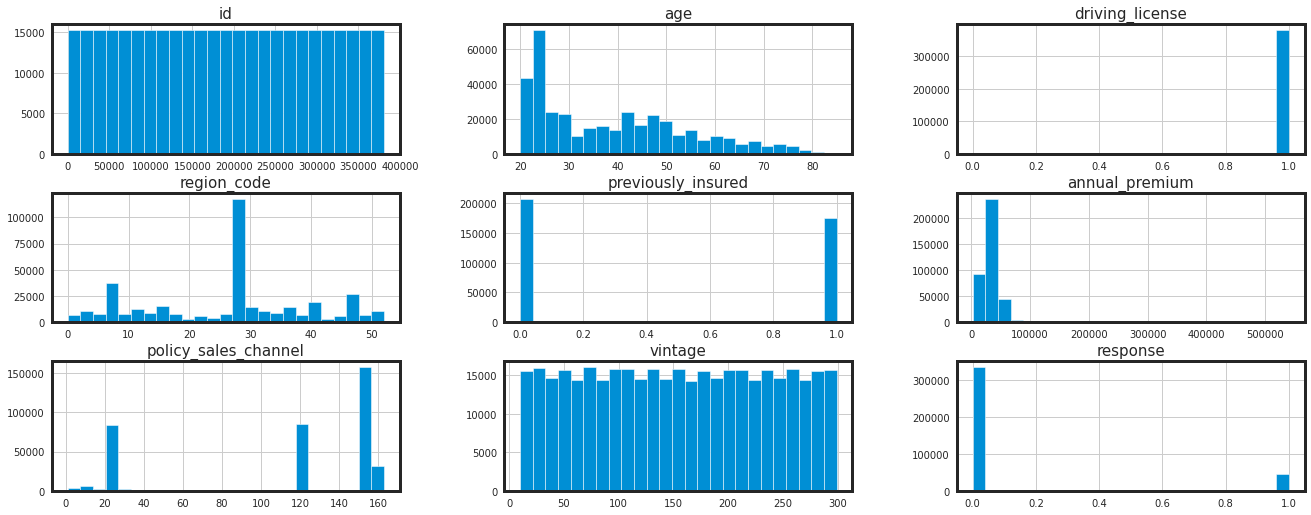

In [16]:
num_attributes.hist(bins = 25);

## 1.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

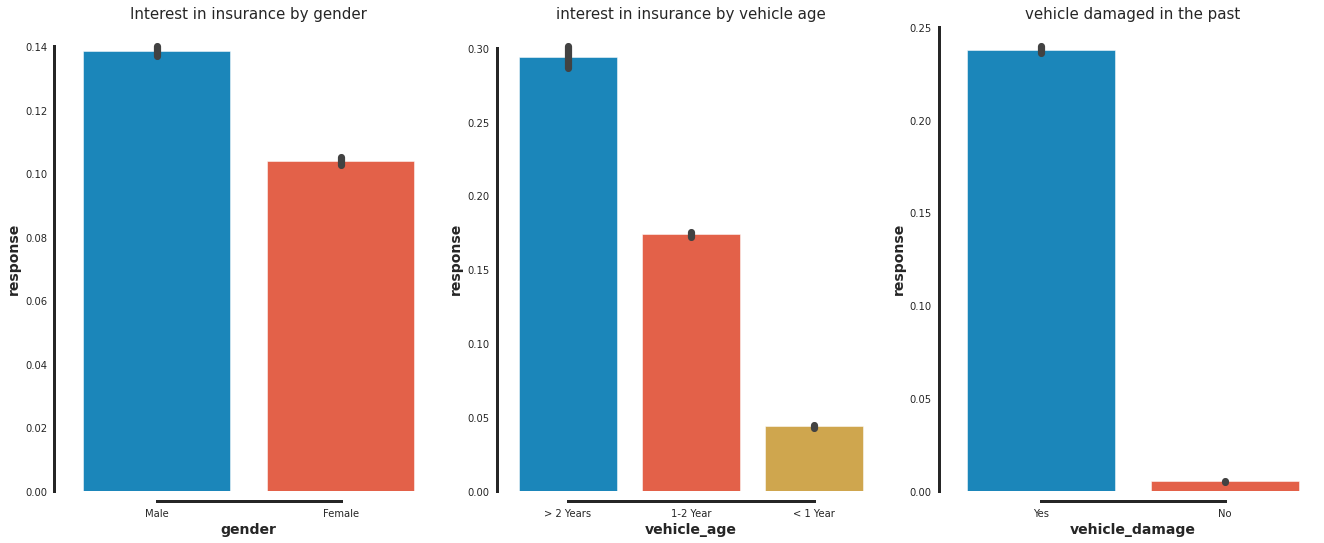

In [18]:
plt.subplot( 1, 3, 1 )
sns.barplot( x='gender', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('Interest in insurance by gender')

plt.subplot( 1, 3, 2 )
sns.barplot( x='vehicle_age', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('interest in insurance by vehicle age')

plt.subplot( 1, 3, 3 )
sns.barplot( x='vehicle_damage', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('vehicle damaged in the past');

## 1.3 Target

In [19]:
df1['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

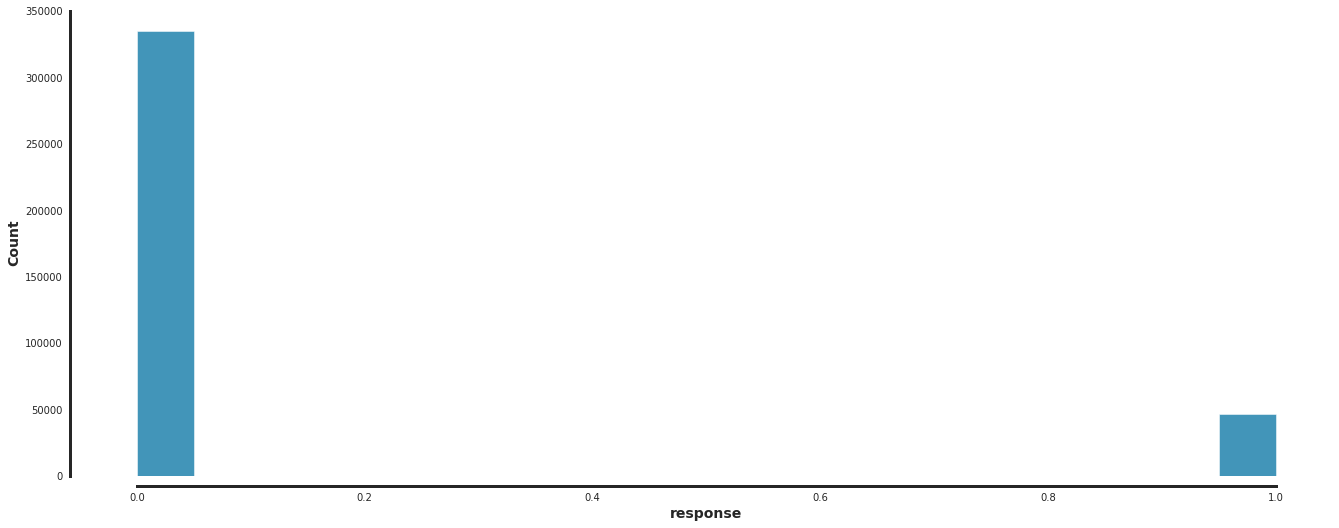

In [20]:
sns.histplot(df1, x = 'response')
sns.despine(offset = 10, trim = True);

# 2.0 Hypothesis

- People is equaly interested in insurance regardless their gender
**FALSE**
- The older the vehicle the greater is the interest in acquiring an insurance
**TRUE**
- If the owner damaged his vehicle before, he is more likely to acquire an insurance
**TRUE**
- People who has driving license are more interested in insurance
**TRUE**
- Different regions have different interesst in insurance
**TRUE**
- Different policy sales channel have different outcome for the customer
**TRUE**
- Who was previosly insured is less likely to acquire a new insurance service (had already showed commitment)
**TRUE**
- The higher Annual Premium, the lower interest in insurance
**FALSE**
- The higher vintage, the higher interest in insurance
**FALSE**
- The higher age, the higher interest in insurance
**TRUE**

# 3.0 Exploratory Data Analysis

In [21]:
df2 = df1.copy()

## 3.1 People who has driving license are more interested in insurance

In [22]:
df2['driving_license'] = df2['driving_license'].map({1: 'Yes', 0: 'No'})

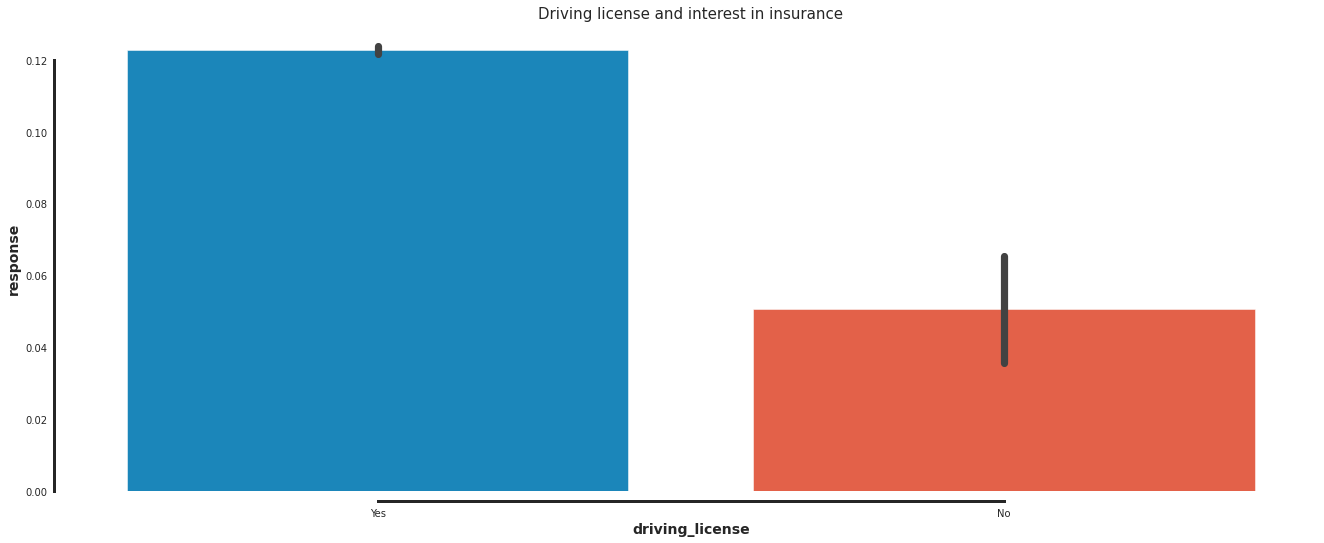

In [23]:
sns.barplot(x = 'driving_license', y = 'response', data = df2)
sns.despine(offset = 10, trim = True)
plt.title('Driving license and interest in insurance'); 

## 3.2 Different regions have different interest in insurance

0          1          2         3          4          5          6         7          8         9          10       11         12         13         14
region_code  38.000000  28.000000  19.000000  4.000000  23.000000  51.000000  24.000000  7.000000  18.000000  3.000000  35.000000  39.0000  52.000000  29.000000  41.000000
response      0.192004   0.187163   0.162866  0.158245   0.153061   0.153005   0.141615  0.131747   0.131574  0.127662   0.124604   0.1236   0.123596   0.123362   0.121776

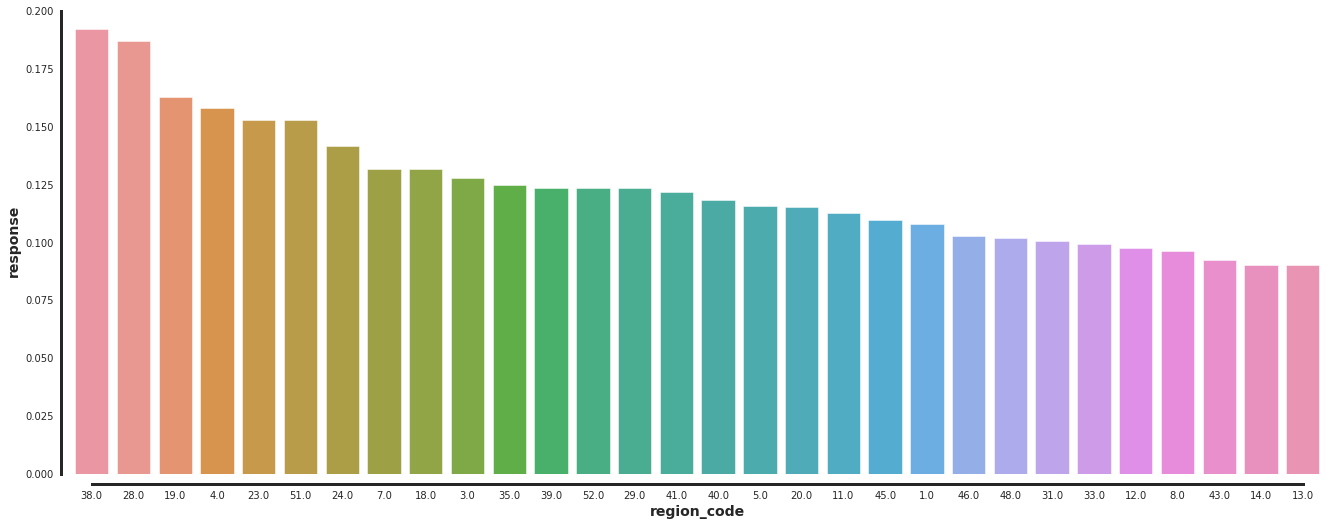

In [24]:
aux = df2[['region_code', 'response']].groupby('region_code').mean().sort_values(by = 'response', ascending = False).reset_index() 
sns.barplot(x = 'region_code', y = 'response', data = aux, order = aux['region_code'].head(30))
sns.despine(offset = 10, trim = True)
aux.head(15).T

## 3.3 Different policy sales channel have different outcome for the customer

0     1          2          3          4           5           6         7           8           9          10         11         12         13         14
policy_sales_channel  123.0  43.0  27.000000  28.000000  36.000000  155.000000  163.000000  3.000000  121.000000  101.000000  87.000000  80.000000  81.000000  158.00000  90.000000
response                1.0   1.0   0.333333   0.333333   0.326923    0.320097    0.304183  0.304015    0.296875    0.285714   0.285714   0.285714   0.285714    0.27439   0.269231

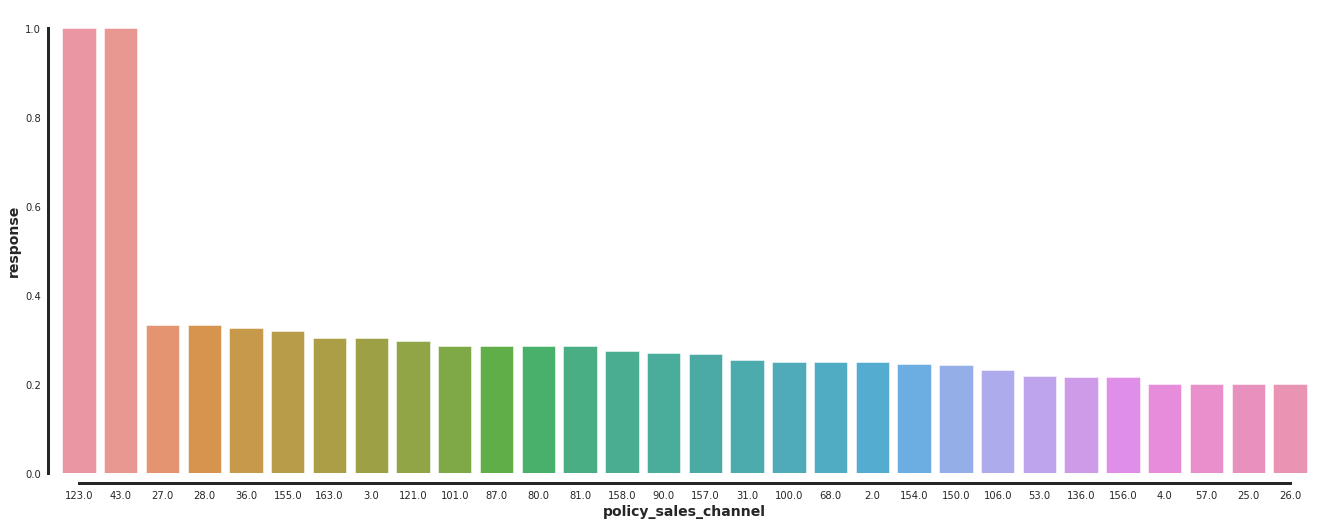

In [25]:
aux = df2[['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().sort_values(by = 'response', ascending = False).reset_index() 
sns.barplot(x = 'policy_sales_channel', y = 'response', data = aux.head(30), order = aux['policy_sales_channel'].head(30))
sns.despine(offset = 10, trim = True);
aux.head(15).T

## 3.4 Who was previosly insured is less likely to acquire a new insurance service

In [26]:
df2['previously_insured'] = df2['previously_insured'].map({1: 'Yes', 0: 'No'})

No     206481
Yes    174628
Name: previously_insured, dtype: int64

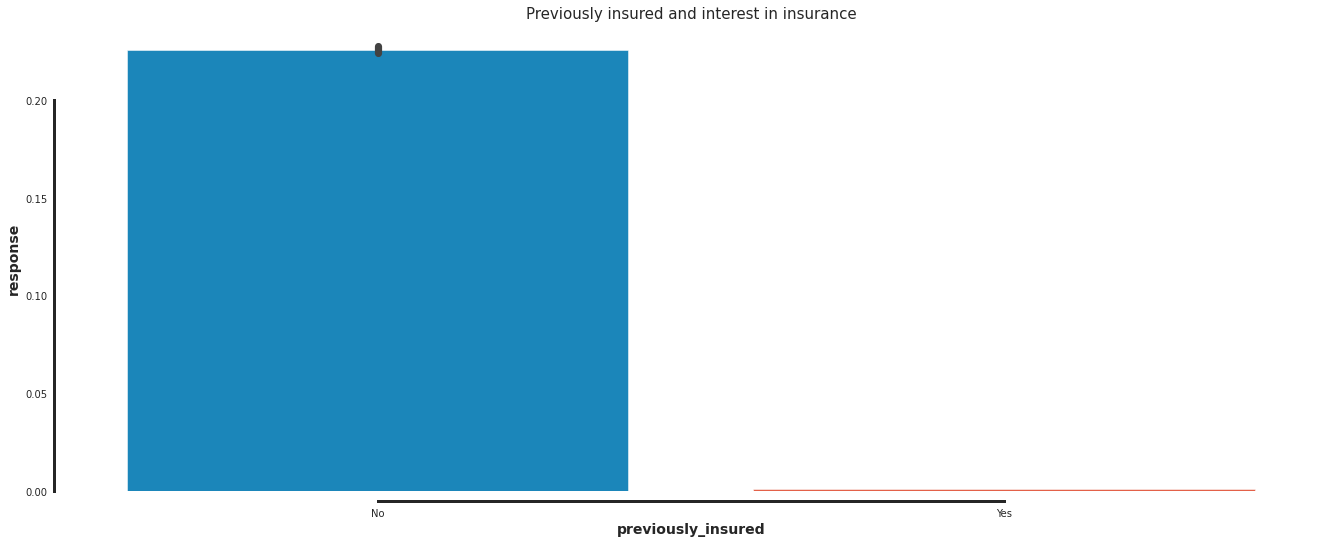

In [27]:
sns.barplot(x = 'previously_insured', y = 'response', data = df2)
sns.despine(offset = 10, trim = True)
plt.title('Previously insured and interest in insurance');

df2['previously_insured'].value_counts()

## 3.5 The higher Annual Premium, the lower interest in insurance

In [28]:
aux1 = df2[df2['response'] == 1]
aux2 = df2[df2['response'] == 0]

x = aux1['annual_premium'].mean()
y = aux2['annual_premium'].mean()

print('Annual premium interested     (mean):', x)
print('Annual premium not interested (mean):', y)

Annual premium interested     (mean): 31604.092742453435
Annual premium not interested (mean): 30419.16027559891


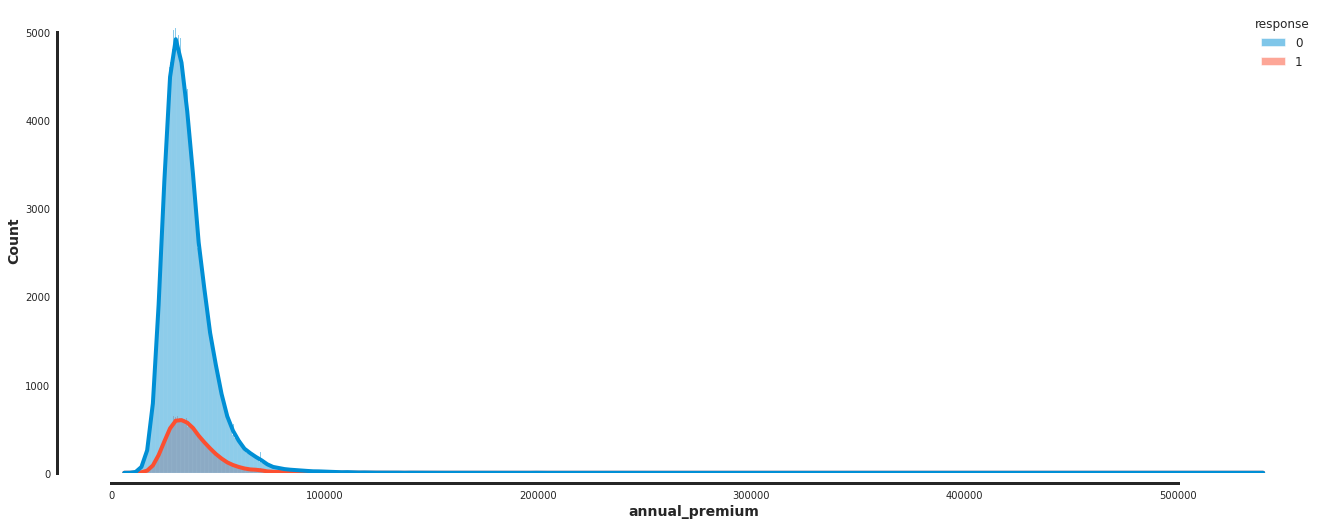

In [29]:
aux3 = df2[df2['annual_premium'] > 3000]

sns.histplot(aux3, x="annual_premium", hue="response", kde = True)
sns.despine(offset = 10, trim = True);

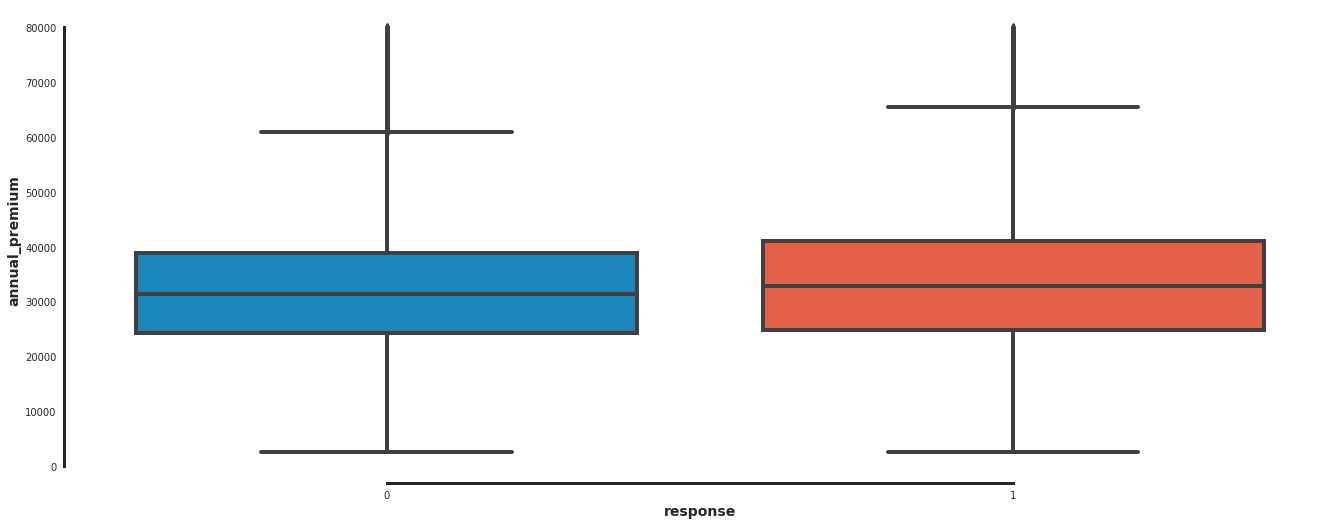

In [30]:
aux3 = df2[df2['annual_premium'] < 80000]
sns.boxplot(x = 'response',y = 'annual_premium', data = aux3)
sns.despine(offset = 10, trim = True);

## 3.6 The higher vintage, the higher interest in insurance

In [31]:
x = aux1['vintage'].mean()
y = aux2['vintage'].mean()

print('vintage of interested     (mean):', x)
print('vintage of not interested (mean):', y)

vintage of interested     (mean): 154.11224577178334
vintage of not interested (mean): 154.38024336197176


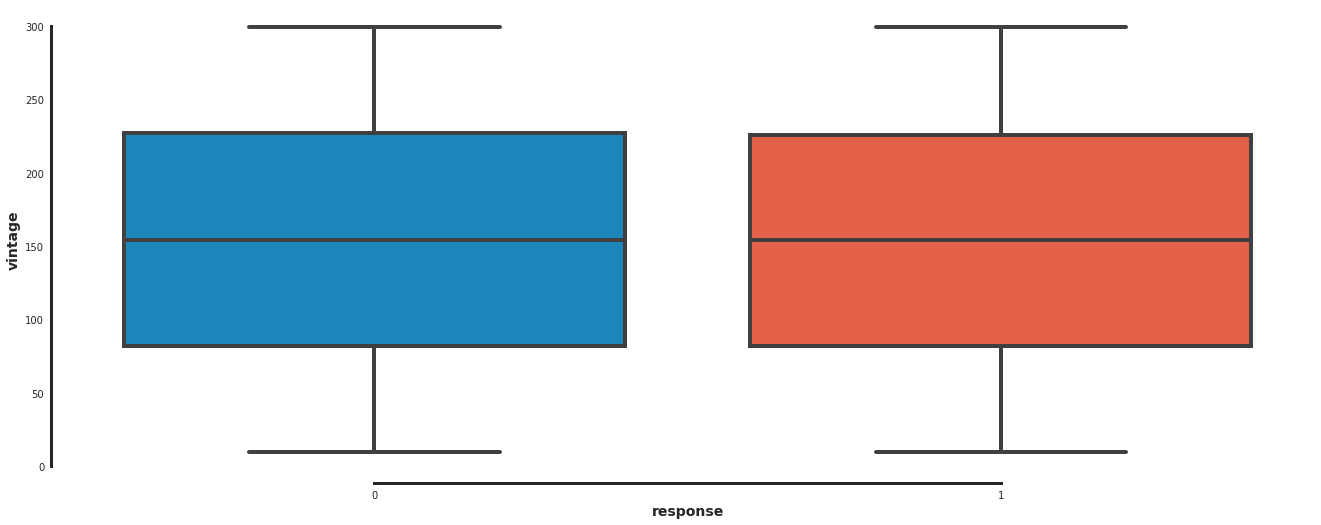

In [32]:
sns.boxplot(x = 'response', y = 'vintage', data = df2)
sns.despine(offset = 10, trim = True);

## 3.7 - The higher age, the higher interest in insurance

In [33]:
x = aux1['age'].mean()
y = aux2['age'].mean()

print('age of interested     (mean):', x)
print('age of not interested (mean):', y)

age of interested     (mean): 43.435559837293944
age of not interested (mean): 38.17822720761725


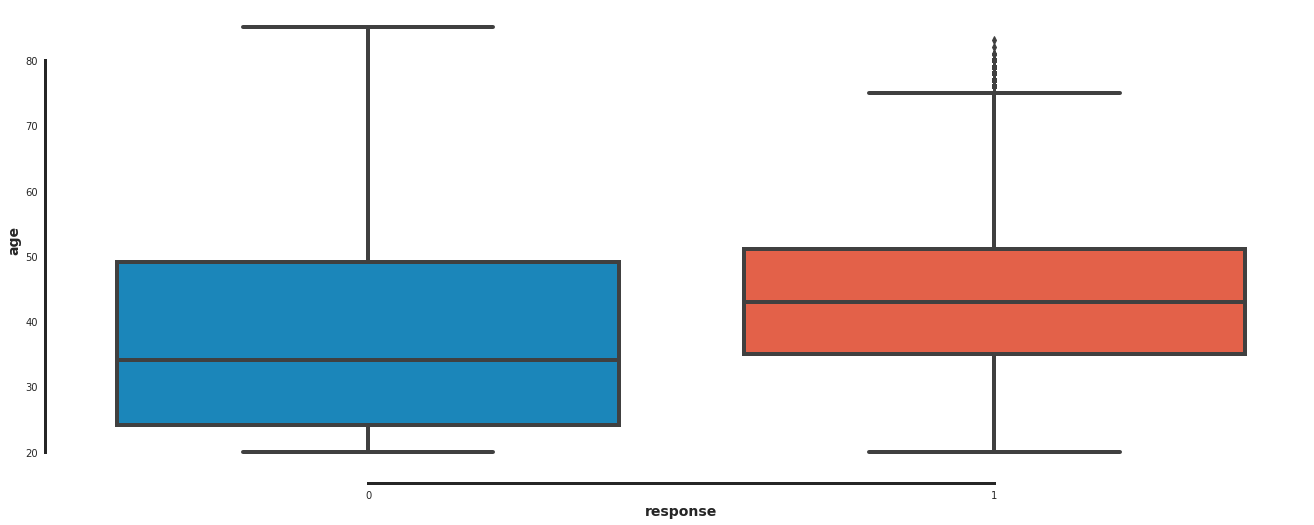

In [34]:
sns.boxplot(x = 'response', y = 'age', data = df2);
sns.despine(offset = 10, trim = True)

# 4.0 Bivariate Analysis

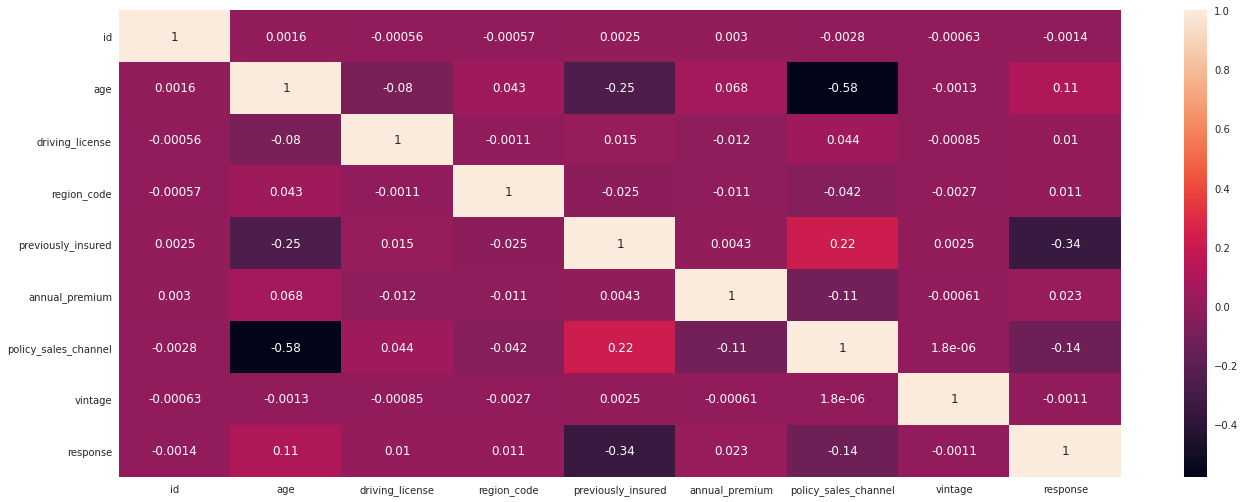

In [35]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

# 5.0 Data Preparation

In [36]:
df3 = df2.copy()

## 5.1 Encoding

In [37]:
#gender
df3['gender'] = df3['gender'].map( {'Male': 1, 'Female':0} )

#previously insured
df3['previously_insured'] = df3['previously_insured'].map( {'Yes': 1, 'No':0} )

#driving license
df3['driving_license'] = df3['driving_license'].map( {'Yes': 1, 'No':0} )

#vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].map( {'Yes': 1, 'No':0} )

## 5.1.1 One hot encoding

In [38]:
# vehicle_age
df3 = pd.get_dummies( df3, columns=['vehicle_age'] )

## 5.1.2 Target Encoding with Kfold

**Region Code**

In [39]:
target_encoder = KFoldTargetEncoder('region_code','response',n_fold=5)
df3 = target_encoder.fit_transform(df3)

df3[['region_code_Kfold_Target_Enc','region_code']].head(6)

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, region_code_Kfold_Target_Enc and, response is 0.13725713378653778.


region_code_Kfold_Target_Enc  region_code
0                      0.185753         28.0
1                      0.129355          3.0
2                      0.186828         28.0
3                      0.114010         11.0
4                      0.122466         41.0
5                      0.099415         33.0

**Policy sales channel**

In [40]:
target_encoder = KFoldTargetEncoder('policy_sales_channel','response',n_fold=5)
df3 = target_encoder.fit_transform(df3)

df3[['policy_sales_channel_Kfold_Target_Enc','region_code']].head(6)

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, policy_sales_channel_Kfold_Target_Enc and, response is 0.26192635929712205.


policy_sales_channel_Kfold_Target_Enc  region_code
0                               0.199385         28.0
1                               0.198666          3.0
2                               0.198666         28.0
3                               0.028425         11.0
4                               0.028729         41.0
5                               0.021735         33.0

## 5.2 Split Dataset

In [41]:
df3.drop(columns = [ 'policy_sales_channel', 'region_code', 'id'], inplace = True)

columns_order = ['gender', 'age', 'driving_license', 'previously_insured',
       'vehicle_damage', 'annual_premium', 'vintage',
       'vehicle_age_1-2 Year', 'vehicle_age_< 1 Year', 'vehicle_age_> 2 Years',
       'region_code_Kfold_Target_Enc',
       'policy_sales_channel_Kfold_Target_Enc', 'response']

#keeping response as the last column for better slicing
df3 = df3.reindex(columns = columns_order)

## 5.2.1 Traning and test data

In [42]:
msk = np.random.rand(len(df)) < 0.80
train = df3[msk]
test = df3[~msk]

In [43]:
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1:]

x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1:]

## 5.3 Rescaling

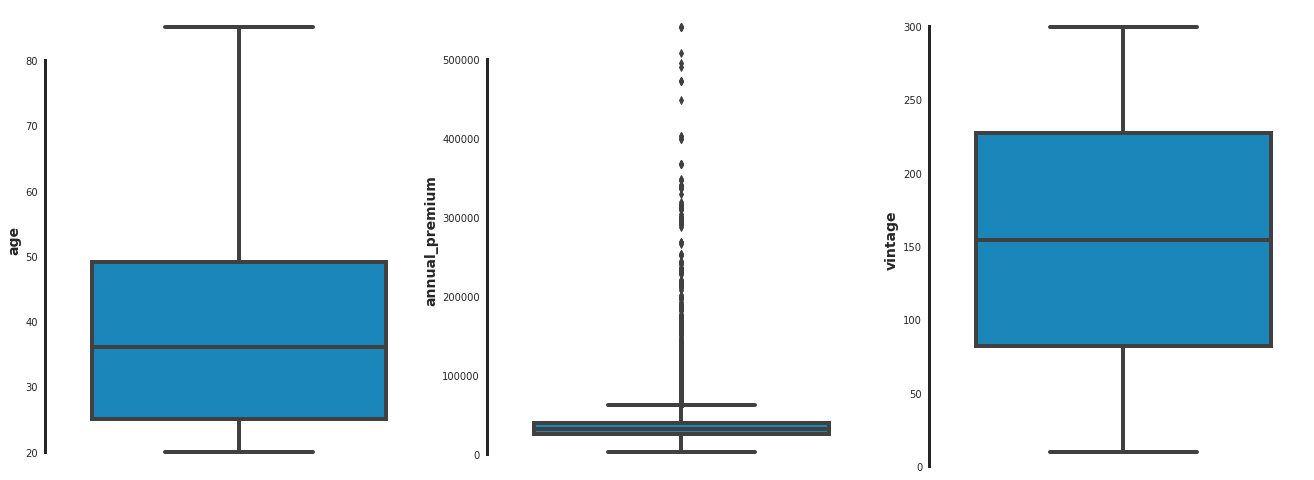

In [44]:
plt.subplot(1,3,1)
sns.boxplot(y = 'age', data = df2)
sns.despine(offset = 10, trim = True)

plt.subplot(1,3,2)
sns.boxplot(y= 'annual_premium', data = df2)
sns.despine(offset = 10, trim = True)

plt.subplot(1,3,3)
sns.boxplot(y= 'vintage', data = df2)
sns.despine(offset = 10, trim = True);

In [45]:
rs = RobustScaler() 
mms = MinMaxScaler() 

#age
x_train['age'] = mms.fit_transform(x_train.loc[:, 'age':].values)
x_test['age'] = mms.transform(x_test.loc[:, 'age':].values)

#vintage
x_train['vintage'] = mms.fit_transform(x_train.loc[:, 'vintage':].values)
x_test['vintage'] = mms.transform(x_test.loc[:, 'vintage':].values)

#anual premium
x_train['annual_premium'] = rs.fit_transform(x_train.loc[:, 'annual_premium':].values)
x_test['annual_premium'] = rs.transform(x_test.loc[:, 'annual_premium':].values)

## 5.4 Target Variable Resampling

### 5.4.1 SMOTE + Tomek Links

In [46]:
print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0           267372
1            37301
dtype: int64

In [47]:
#resample
x_train_res, y_train_res = SMOTETomek(random_state = 42).fit_resample(x_train, y_train)

In [48]:
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0           262546
1           262546
dtype: int64

# 6.0 Feature Selection

## 6.1.1 Feature Analysis

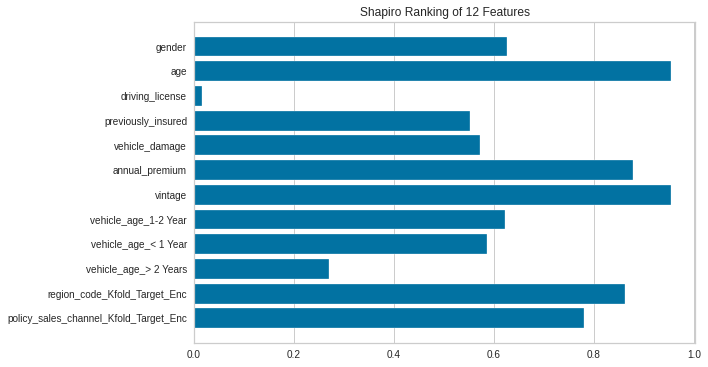

In [274]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x_train_res, y_train_res)           
visualizer.transform(x_train_res)        
visualizer.show();              

## 6.1.2 Boruta Algorithm (Wrapper Method) 

In [51]:
x_train_res_s = x_train_res.values
y_train_res_s = y_train_res.values.ravel()

In [52]:
#training and test dataset for Boruta
x_train_n = x_train_res
y_train_n = y_train_res

#define RandomForestClassifier
rf = RandomForestClassifier( n_jobs = -1 )

boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( x_train_n, y_train_n )

In [53]:
ols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [54]:
cols_selected_boruta

In [55]:
cols_not_selected_boruta

## 6.1.1 Recursive Feature Elimination with Cross Validation

Optimal number of features : 3


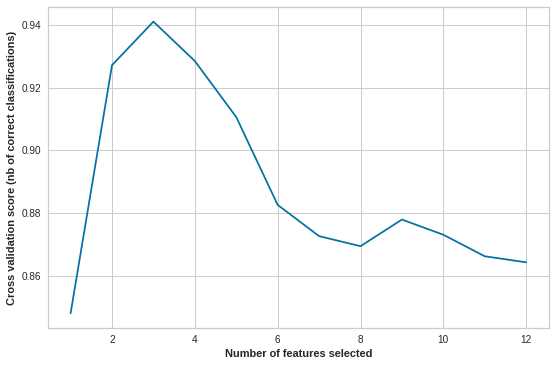

In [62]:
#Create the RFE object and compute a cross-validated score.
et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 )

min_features_to_select = 1  # Minimum number of features to consider

rfeet = RFECV(estimator = et, step = 1, cv = StratifiedKFold(2),
              scoring = 'precision',
              min_features_to_select= min_features_to_select)

rfeet.fit(x_train_res_s, y_train_res_s)

print("Optimal number of features : %d" % rfeet.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfeet.grid_scores_) + min_features_to_select),
         rfeet.grid_scores_)
plt.show()

In [63]:
print('--- RFECV Selected Columns ---')
print(' ')

for i in range(x_train.shape[1]):
    
    if rfeet.support_[i] == True:
        print(str(df3.columns[i]))
        print('Rank: %.2f' % rfeet.ranking_[i])
        print(' ')
    else:
        pass

--- RFECV Selected Columns ---
 
age
Rank: 1.00
 
vehicle_damage
Rank: 1.00
 
policy_sales_channel_Kfold_Target_Enc
Rank: 1.00
 


# 7.0 Modeling

**Selected columns from feature analysis and selection**

In [49]:
cols_selected = [   'age',
                    'vehicle_damage',
                    'annual_premium',
                    'vintage',
                    'region_code_Kfold_Target_Enc',
                    'policy_sales_channel_Kfold_Target_Enc',
                    'previously_insured'
                ]

In [50]:
x_train_res = x_train_res[cols_selected]
x_test = x_test[cols_selected]

## 7.1 Logistic Regression

In [68]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 ) 

# model training
lr_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_lr   = lr_model.predict_proba( x_test )
yhat_lr_1 = lr_model.predict( x_test )

#metrics 

data = x_test.copy()
data['response'] = y_test.copy()
data['score'] = yhat_lr[:, 1].tolist()
data = data.sort_values('score', ascending=False)

print('Precision@K: ' + str(precision_at_k(data)))
print('Precision: '   + str(precision_score(y_test,yhat_lr_1 )))
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_test,yhat_lr_1 )))
print('Accuracy: ' + str(accuracy_score(y_test,yhat_lr_1 )))

Precision@K: 0.3257837108144593
Precision: 0.2708455440046889
Balanced Accuracy: 0.7902500900160406
Accuracy: 0.6825317913025276


## 7.2 K-Nearest Neighbors

In [63]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train_res,y_train_res.values.ravel())
    yhat = knn_model.predict(x_test)
    mean_rcc[n-1] = precision_score(y_test, yhat)

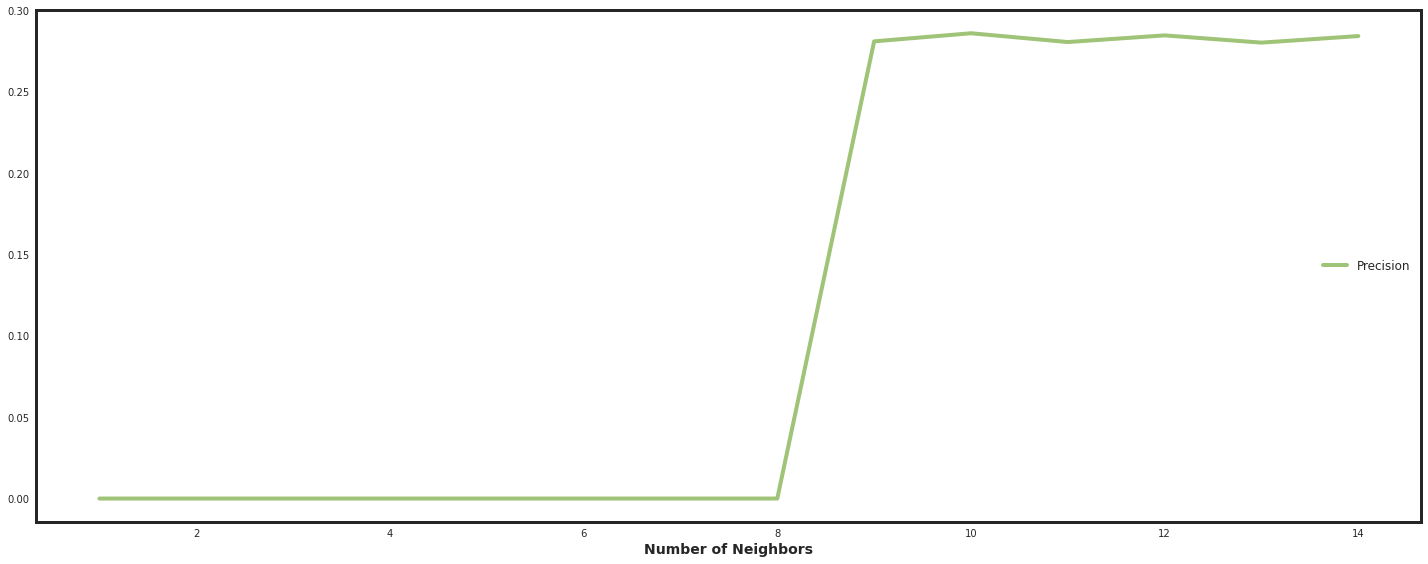

In [64]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [69]:
# model definition with k = 10
knn_model = nh.KNeighborsClassifier( n_neighbors = 10 )

# model training
knn_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_knn   = knn_model.predict_proba( x_test )
yhat_knn_1 = knn_model.predict( x_test ) 

#metrics 
data = x_test.copy()
data['response'] = y_test.copy()
data['score'] = yhat_knn[:, 1].tolist()
data = data.sort_values('score', ascending=False)

print('Precision@K: ' + str(precision_at_k(data)))
print('Precision: '   + str(precision_score(y_test,yhat_knn_1 )))

Precision@K: 0.29573521323933805
Precision: 0.2861785186748259


## 7.3 Extra Trees

In [70]:
# model definition
et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_et = et.predict_proba(x_test)
yhat_et_1 = et.predict(x_test)

#metrics
data = x_test.copy()
data['response'] = y_test.copy()
data['score'] = yhat_et[:, 1].tolist()
data = data.sort_values('score', ascending=False)

print('Precision@K: ' + str(precision_at_k(data)))
print('Precision: '   + str(precision_score(y_test,yhat_et_1 )))

Precision@K: 0.30183490825458725
Precision: 0.32224183583406885


# 7.4 XGBoost Classifier 

In [71]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 10, 
                              subsample = 0.7,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9)

#model training
model_xgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict_proba( x_test )
yhat_xgb_1 = model_xgb.predict( x_test )

#metrics
data = x_test.copy()
data['response'] = y_test.copy()
data['score'] = yhat_xgb[:, 1].tolist()
data = data.sort_values('score', ascending=False)

print('Precision@K: ' + str(precision_at_k(data)))
print('Precision: '   + str(precision_score(y_test,yhat_xgb_1 )))

Precision@K: 0.2896855157242138
Precision: 0.2897961339389458


## 7.5 Gaussian NB Classifier

In [72]:
#model definition
model_nb = GaussianNB()

#train model
model_nb.fit( x_train_res, y_train_res.values.ravel() )

#prediction
yhat_nb = model_nb.predict_proba( x_test )
yhat_nb_1 = model_nb.predict( x_test )

#metrics
data = x_test.copy()
data['response'] = y_test.copy()
data['score'] = yhat_nb[:, 1].tolist()
data = data.sort_values('score', ascending=False)

print('Precision@K: ' + str(precision_at_k(data)))
print('Precision: '   + str(precision_score(y_test,yhat_nb_1 )))

Precision@K: 0.3060346982650867
Precision: 0.25096841071526


## 7.6 Random Forest Classifier

In [77]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 0)

#train model
model_rf.fit( x_train_res, y_train_res.values.ravel() )

#predict
yhat_rf = model_nb.predict_proba( x_test )
yhat_rf_1 = model_nb.predict( x_test )

#metrics
data = x_test.copy()
data['response'] = y_test.copy()
data['score'] = yhat_rf[:, 1].tolist()
data = data.sort_values('score', ascending=False)

print('Precision@K: ' + str(precision_at_k(data)))
print('Precision: '   + str(precision_score(y_test,yhat_rf_1 )))

Precision@K: 0.3060346982650867
Precision: 0.25096841071526


## 8.0 Real Model Performance: Cross Validation with Learning to Rank metrics

In [83]:
df4 = df3.copy()

In [84]:
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, 5, df4, Verbose = False)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, 5, df4, Verbose = False)
et_val = cross_validation(et, x_train_res, y_train_res, 5, df4, Verbose = False)
knn_val = cross_validation(knn_model, x_train_res, y_train_res, 5, df4, Verbose = False)
nb_val = cross_validation(model_nb, x_train_res, y_train_res, 5, df4, Verbose = False)
rf_val = cross_validation(model_rf, x_train_res, y_train_res, 5, df4, Verbose = False)

In [85]:
results = pd.concat([xgb_val,lr_val,et_val,knn_val,nb_val,rf_val])
results.sort_values(by = 'Precision Mean', ascending = False)

Model Name  Balanced Accuracy Mean  Precision Mean  Precision STD  Precision@K Mean  Precision@K STD  Recall@K Mean  Recall@K STD
0    ExtraTreesClassifier                  0.9158          0.8878         0.0016            0.9991           0.0003         0.0761        0.0000
0           XGBClassifier                  0.8515          0.8094         0.0068            1.0000           0.0000         0.0762        0.0000
0    KNeighborsClassifier                  0.8461          0.7899         0.0011            0.9291           0.0075         0.0708        0.0006
0      LogisticRegression                  0.7968          0.7318         0.0009            0.7419           0.0094         0.0565        0.0007
0  RandomForestClassifier                  0.7956          0.7188         0.0012            0.8387           0.0377         0.0639        0.0029
0              GaussianNB                  0.7894          0.7099         0.0010            0.7917           0.0056         0.0603        0.0004

# 9.0 Hyperparameter Fine Tuning

We will proceed with both XGBoost and ExtraTrees Classifier, using Optuna framework to tune them

## 9.1 Extra Trees Classifier

In [129]:
def objective(trial):

        random_state = 42
        n_jobs = -1
        max_depth = trial.suggest_int("max_depth", 80, 120)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    

        classifier_obj = ExtraTreesClassifier( random_state      = random_state,
                                                  n_jobs            = n_jobs,
                                                  max_depth         = max_depth,
                                                  n_estimators      = n_estimators,
                                                  min_samples_split = min_samples_split,
                                                  min_samples_leaf  = min_samples_leaf
                                                  ) 

  
        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df4, Verbose = False)
    
        return result['Precision Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Precision: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

t is trial 0 with value: 0.8859.
[I 2021-03-08 00:45:08,764] Trial 9 finished with value: 0.7754 and parameters: {'max_depth': 117, 'n_estimators': 104, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8859.
[I 2021-03-08 00:45:29,422] Trial 10 finished with value: 0.7938 and parameters: {'max_depth': 80, 'n_estimators': 85, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8859.
[I 2021-03-08 00:45:58,455] Trial 11 finished with value: 0.8856 and parameters: {'max_depth': 109, 'n_estimators': 89, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8859.
[I 2021-03-08 00:46:26,950] Trial 12 finished with value: 0.8882 and parameters: {'max_depth': 107, 'n_estimators': 88, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.8882.
[I 2021-03-08 00:46:49,000] Trial 13 finished with value: 0.794 and parameters: {'max_depth': 105, 'n_estimators': 91, 'min_samples_split': 2, 'min_sam

In [51]:
best_hyperparameters_et = {'max_depth': 103, 'n_estimators': 94, 'min_samples_split': 2, 'min_samples_leaf': 1}

## 9.2 XGBoost

In [87]:
def objective(trial):

        
        random_state = 42
        n_jobs =  -1
        verbosity = 0
        objective = "binary:logistic"
        booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
        alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
        max_depth = trial.suggest_int("max_depth", 80, 120)
        eta = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        subsample = trial.suggest_float("subsample", 0.1, 1.0, log = True)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 15)
        colsample_bytree = trial.suggest_float("subsample", 0.1, 1.0, log=True)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
    

        classifier_obj = xgb.XGBClassifier( random_state     = random_state,
                                            n_jobs           = n_jobs,
                                            verbosity        = verbosity, 
                                            objective        = objective,
                                            booster          = booster,
                                            alpha            = alpha,
                                            max_depth        = max_depth,
                                            eta              = eta,
                                            gamma            = gamma,
                                            grow_policy      = grow_policy,
                                            subsample        = subsample,
                                            min_child_weight = min_child_weight,
                                            colsample_bytree = colsample_bytree,
                                            n_estimators     = n_estimators
                                            )
        

        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df4, Verbose = False)
        
        return result['Precision Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Precision: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-03-08 14:52:57,426] A new study created in memory with name: no-name-07caf55a-5cba-4863-9f52-65a189f29ede
[I 2021-03-08 14:54:12,019] Trial 0 finished with value: 0.9917 and parameters: {'booster': 'gbtree', 'alpha': 0.00028685834185709284, 'max_depth': 95, 'eta': 1.1984610863130654e-06, 'gamma': 0.00037830591951810023, 'grow_policy': 'depthwise', 'subsample': 0.13349250463977544, 'min_child_weight': 3, 'n_estimators': 91}. Best is trial 0 with value: 0.9917.
[I 2021-03-08 14:54:17,633] Trial 1 finished with value: 0.726 and parameters: {'booster': 'gblinear', 'alpha': 0.03509963274983529, 'max_depth': 106, 'eta': 0.0063016693345719025, 'gamma': 0.05342363917078442, 'grow_policy': 'lossguide', 'subsample': 0.17668771952003198, 'min_child_weight': 13, 'n_estimators': 116}. Best is trial 0 with value: 0.9917.
[I 2021-03-08 14:56:55,665] Trial 2 finished with value: 0.9946 and parameters: {'booster': 'gbtree', 'alpha': 0.515943615147955, 'max_depth': 80, 'eta': 0.01168649074891257

KeyboardInterrupt: 

In [ ]:
best_hyperparameters_xgb = {'booster': 'gbtree', 'alpha': 0.008258022766836732, 'max_depth': 89, 'eta': 1.020910852361211e-08, 'gamma': 0.0197011089732516, 'grow_policy': 'depthwise', 'subsample': 0.41663764161950073, 'min_child_weight': 2, 'n_estimators': 95}

# 10.0 Final Model

## 10.2 Extra Trees

In [50]:
#definition
model_et = ExtraTreesClassifier( random_state      = 42,
                                 n_jobs            = -1,
                                 max_depth         = 103,
                                 n_estimators      = 94,
                                 min_samples_split = 2,
                                 min_samples_leaf  = 1
                                ) 
#training
model_et.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_et = model_et.predict_proba(x_test)
yhat_et_1 = model_et.predict(x_test)

# 11.0 Business Performance

## By using 26% of test data, in which wold translate as 20 thousand calls by the sales team, the model would be able to identify 64% people out of the total people interested in purchasing the insurance

In [54]:
data = x_test.copy()

data['response'] = y_test.copy()
data['score'] = yhat_et[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [59]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(percent_of_dataset)
print(recall_at_20000)

0.2620682425703653
0.6414835164835165


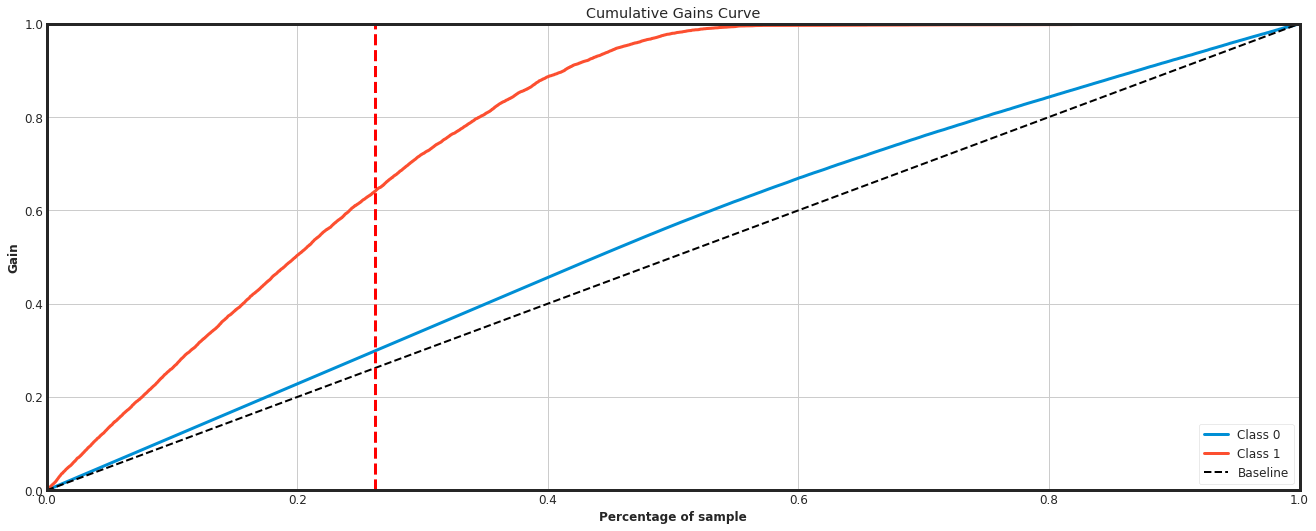

In [90]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_et)
plt.axvline(0.2620, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## By using a little less then 34% of test data, in which wold translate as 26 thousand and 4 hundred calls by the sales team, the model would be able to identify 80% people out of the total people interested in purchasing the insurance

In [80]:
percent_of_dataset = 26400 / len(data)
recall_at_26400 = recall_at_k(data, k = 26400)

print(percent_of_dataset)
print(recall_at_26400)

0.34593008019288224
0.8000845308537616


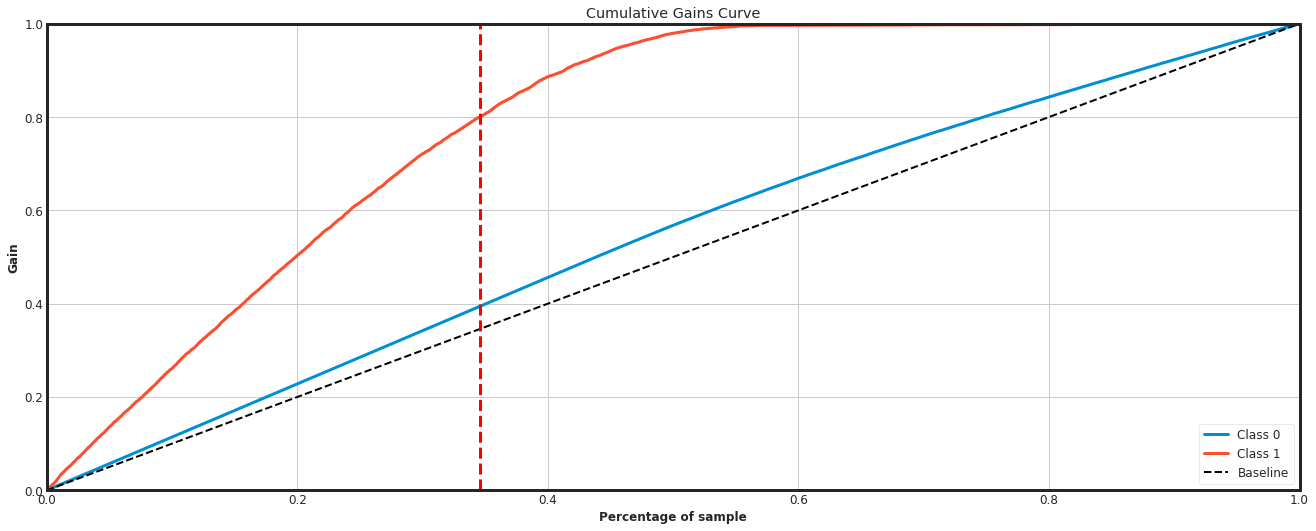

In [89]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_et)
plt.axvline(0.3459, 0, 1, color='red', ls='--', lw=3)
plt.show(); 

## By Making 20 thousand calls, the model proposed is roughly 2,5 times better than random choice

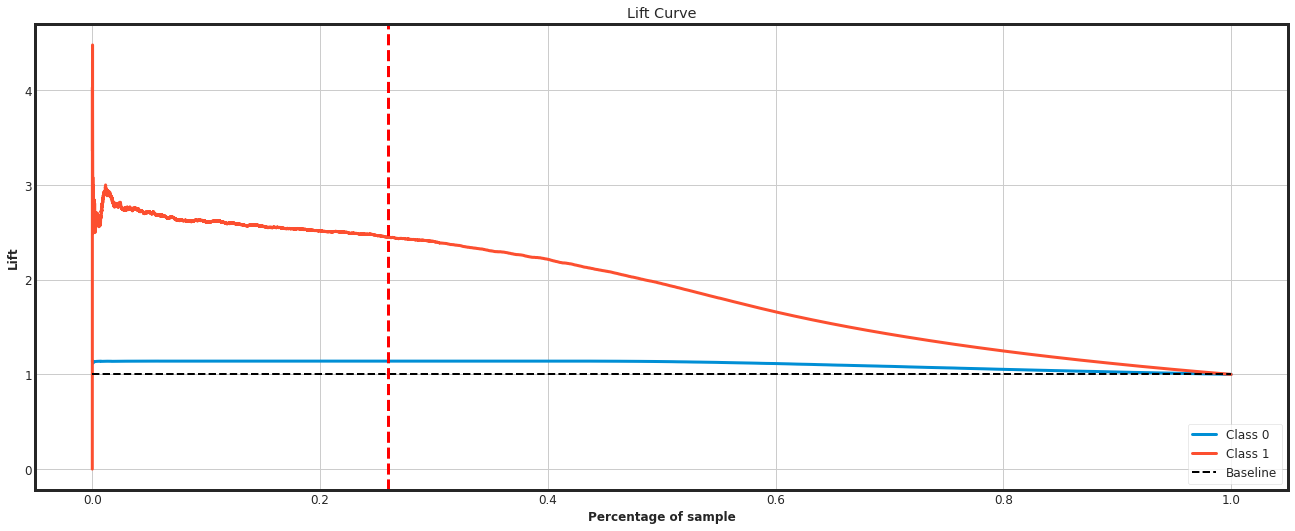

In [93]:
skplt.metrics.plot_lift_curve(y_test, yhat_et)
plt.axvline(0.26, 0, 1, color='red', ls='--', lw=3);

## Baseline model would predict 26% of all people interested in insurance by making 20 thousand calls, whereas, our model, would predict 64%. If each insurance is 1000 this represents a diference of 29 million dollars in 20 thousand calls

In [101]:
random_choice = (26/100) * len(data)
model         = (64/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

19842160 revenue with random choice
48842240 revenue with model
difference in $: 29000080


## With 26 thousand calls and 4 hundred, our model would predict 80% of all people interested, and the difference from baseline would rise to 35,1 million dollars

In [102]:
random_choice = (34/100) * len(data)
model         = (80/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

25947440 revenue with random choice
61052800 revenue with model
difference in $: 35105360
